# Computing statistics from trajectories

In [2]:
#!/usr/bin/env python
# coding: utf-8

import contracts
contracts.disable_all()

import geometry as geo
import math 
import numpy as np
from os import path, listdir
from scipy import stats
import yaml
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from math import ceil

import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_svg, ipython_draw_html
from duckietown_world.world_duckietown.tile import get_lane_poses
from duckietown_world import draw_static


# import geometry_msgs
# import geometry_msgs.msg
# import geometry_msgs.msg._TransformStamped
# import geometry_msgs.msg._TransformStamped as TransformStamped

INFO:dt-world:duckietown-world 5.1.2
INFO:zuper-typing:zuper-typing 5.3.0
INFO:zuper-commons:zuper-commons 5.0.11


## Goal of the notebook

Familiarize yourself with duckietown world, with an example. The goal is to plot the average trajectory along with its standard deviation for a set of experiments done on fixed map and starting conditions. 

Let's start with visualizing the map.

In [3]:
from os import path, listdir
import json
import yaml
import matplotlib.pyplot as plt
import numpy as np
# from scipy import interpolate

experiment_dir = ''

logs_path = path.join(experiment_dir, '../data/BenchmarkXY')

In [4]:

logs_path = path.join(experiment_dir, '../data/BenchmarkXY/benchmarks/same_bm')

localization_logs = [path.join(logs_path, f) for f in listdir(logs_path) if path.isfile(path.join(logs_path, f))]
print(f'Logs found: {localization_logs}')

nb_bm_found = len(localization_logs)
all_logs = []
names=[]
compare_a = []
compare_b = []
i = 0
for filename in localization_logs:
    with open(filename, 'r') as file:
        current = []
        names.append(path.basename(filename))
        current.append(yaml.safe_load(file))
        
    all_logs.append(current)

    i += 1

number_of_tests = i


compare_a = []
i = 0

for filename in localization_logs:
    with open(filename, 'r') as file:
        if i == 0:
            name_a = filename
            compare_a.append(yaml.safe_load(file))
    i += 1

name_a = path.basename(name_a)
name = name_a.replace("_benchmark_results_test_ 02.yaml","")

Logs found: ['../data/BenchmarkXY/benchmarks/same_bm/blabla_benchmark_results_test_ 02.yaml', '../data/BenchmarkXY/benchmarks/same_bm/blabla_benchmark_results_test_ 04.yaml', '../data/BenchmarkXY/benchmarks/same_bm/blabla_benchmark_results_test_ 03.yaml', '../data/BenchmarkXY/benchmarks/same_bm/blabla_benchmark_results_test_01.yaml']
4


In [58]:
print(all_logs[0])

[{'Benchmark_Type': 'Lane Following', 'Results': {'Number_of_completed_laps': 0, 'Number_of_tiles_covered': 6, 'Avg_time_needed_per_tile': 3.0, 'Time_needed_per_straight_tile_sec': 'ToDo', 'Time_needed_per_curved_tile': 'ToDo', 'Theoretical_length_of_benchmark': 50.0, 'Length_of_recorded_bag': 50.2666, 'Actual_length_of_benchmark': 18.0, 'Tolerance_out_of_sight': 3.0, 'Out_of_sight': True, 'Time_out_of_sight': 18.0, 'Tolerance_too_slow_sec': 30.0, 'Too_slow': False, 'Time_too_slow': 18.0, 'Position_too_slow': 'ToDo', 'Abs_Ground_truth_wt_mean_offset_mine_1': 0.0556, 'Abs_Ground_truth_wt_mean_angle_mine_1': 7.5957, 'Abs_Ground_truth_wt_median_offset_mine_1': 0.0488, 'Abs_Ground_truth_wt_median_angle_mine_1': 7.4255, 'Abs_Ground_truth_wt_std_offset_mine_1': 0.038, 'Abs_Ground_truth_wt_std_angle_mine_1': 4.9629, 'Abs_Ground_truth_wt_mean_offset_mine_2': 0.0689, 'Abs_Ground_truth_wt_mean_angle_mine_2': 7.5957, 'Abs_Ground_truth_wt_median_offset_mine_2': 0.0687, 'Abs_Ground_truth_wt_median_

In [59]:
no_meaningful_comp = ['Tolerance_out_of_sight', 'Tolerance_too_slow_sec', 'Theoretical_length_of_benchmark',\
                     'int_trajs', 'all_trajectories', 'time_wt', 'time_db', 'time_db_true','angle_wt','angle_db',\
                      'angle_wt_mine_1','angle_wt_mine_2','angle_db_true','offset_wt','offset_db','offset_wt_mine_1',\
                      'offset_wt_mine_2','offset_db_true']
no_meaningful_rel_comp = ['Out_of_sight', 'Too_slow']
list_of_comp_todo = ['Position_too_slow', 'Time_needed_per_straight_tile_sec', 'Time_needed_per_curved_tile']

nb_of_properties = len(all_logs[0][0]['Results'])

def Average(lst): 
    lst_abs = [abs(x) for x in lst]
    return sum(lst_abs) / len(lst) 

In [60]:
for i in range(0, nb_bm_found):
    if all_logs[0][0]['Benchmark_Type'] != all_logs[i][0]['Benchmark_Type']:
        print("This avg calculation work as the results come from two different Benchmarks")

In [61]:
benchmark_std = path.join(experiment_dir, 'out/benchmark_std.yaml')
benchmark_mean = path.join(experiment_dir, 'out/'+ name + '_benchmark_mean.yaml')
benchmark_std_graph = path.join(experiment_dir, 'out/benchmark_std_graph.jpg')
benchmark_boxplot_graph = path.join(experiment_dir, 'out/benchmark_boxplot_graph.jpg')

In [62]:
def get_unit(info):
    if info == 'Number_of_completed_laps':
        unit = 'laps'
    elif info == 'Number_of_tiles_covered':
        unit = 'tiles'
    elif info == 'Avg_time_needed_per_tile':
        unit = 'seconds per tile'
    elif info == 'Time_needed_per_straight_tile_sec':
        unit = 'seconds per tile'
    elif info == 'Time_needed_per_curved_tile':
        unit = 'seconds per tile'
#         elif info == 'Theoretical_length_of_benchmark':
#             unit = 'seconds'
    elif info == 'Length_of_recorded_bag':
        unit = 'seconds' 
    elif info == 'Actual_length_of_benchmark':
        unit = 'seconds'   
    elif info == 'Out_of_sight':
        unit = ' '  
    elif info == 'Time_out_of_sight':
        unit = 'seconds' 
    elif info == 'Too_slow':
        unit = ' '  
    elif info == 'Time_too_slow':
        unit = 'seconds' 
    elif info == 'Position_too_slow':
        unit = ' '
    elif info == 'Ground_truth_wt_std_offset':
        unit = 'meters' 
    elif info == 'Ground_truth_wt_std_angle':
        unit = 'radians' 
    elif info == 'Ground_truth_wt_mean_offset':
        unit = 'meters' 
    elif info == 'Ground_truth_wt_mean_angle':
        unit = 'radians' 
    elif info == 'Measurements_db_std_offset':
        unit = 'meters'
    elif info == 'Measurements_db_std_angle':
        unit = 'radians' 
    elif info == 'Measurements_db_mean_offset':
        unit = 'meters' 
    elif info == 'Measurements_db_mean_angle':
        unit = 'radians' 
    elif info == 'std_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'std_diff_btw_estimation_and_ground_truth_angle':
        unit = 'radians'
    elif info == 'mean_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'mean_diff_btw_estimation_and_ground_truth_angle':
        unit = 'radians'
    else:
        unit = 'Uuuups' 
    
    return unit

def count_true(results):
    counter = 0
    for i in range(0,len(results)):
        if results[i] == True:
            counter += 1
    return counter

In [6]:
# Plots mean and Standard Deviation

import statistics
mean_bm = {'Benchmark_Type': all_logs[0][0]['Benchmark_Type']}
std_bm = {'Benchmark_Type': all_logs[0][0]['Benchmark_Type']}
all_results_mean = {}
all_results_std = {}
nb_of_oos = 0
nb_of_ts = 0

fig1, axes1 = plt.subplots(nrows=ceil((nb_of_properties-len(no_meaningful_comp)-len(list_of_comp_todo)-\
                                    len(no_meaningful_rel_comp))/2), ncols=2)
fig2, axes2 = plt.subplots(nrows=ceil((nb_of_properties-len(no_meaningful_comp)-len(list_of_comp_todo)-\
                                    len(no_meaningful_rel_comp))/2), ncols=2)
fig1.subplots_adjust(hspace=0.5)
fig1.suptitle('Error bar plot', y=.895)
fig2.subplots_adjust(hspace=0.5)
fig2.suptitle('Boxplot', y=.895)

mean_bm.update({'Number of tests ran': number_of_tests})

count = 0

for i, prop in enumerate(all_logs[0][0]['Results']):
    results = []
    std_exist = False
    if (prop not in list_of_comp_todo) and (prop not in no_meaningful_comp):
        print(prop)
        for j in range(0, nb_bm_found):
            results.append(all_logs[j][0]['Results'][prop])
            
        if type(results[0]) != bool:
            avg_result = Average(results)
            median_result = statistics.median(results)
            std_result = statistics.stdev(results)
            
            unit = get_unit(prop)
            # coefficient of variation calculation:
            # if lower than 1, the std can be considered small enough and one can stop running tests
            # https://www.researchgate.net/post/What_do_you_consider_a_good_standard_deviation
            if avg_result != 0:
                cv = std_result/avg_result
                cv_median = std_result/median_result
                std_exist = True
#             print(cv)
            
        else:
            std_result = 'Not applicable'
            counter = count_true(results)
            avg_result = '{} failures'.format(counter)
    else:
        std_result = 'ToDo'
        avg_result = 'ToDo'
    if std_exist:
        if cv >= 1.0:
            color = 'red'
            answer = 'no'
        elif cv < 1.0:
            color = 'green'
            answer = 'yes'
        else:
            color = 'black'
            answer = 'Sth went wrong'
        all_results_std.update({prop: {'Std': std_result, 'Mean': avg_result, \
                                'coefficient of variation calculation': cv, \
                                'Enough tests run for meaningful BM analyzis': answer}})
        # Figure 1: Mean and Std
        ax1 = axes1.flatten()[count]
        ax1.set_ylabel(unit)
        ax1.set_xlabel(prop)
        ax1.set_xticklabels([])
        ax1.errorbar(1, avg_result, yerr=std_result, linestyle='None', marker='^', ecolor = color)
        ax1.xaxis.label.set_color(color)
        # Figure 2: Boxplot:
        ax2 = axes2.flatten()[count]
        ax2.set_ylabel(unit)
        ax2.set_xlabel(prop)
        test = [1.0,2.0,3.0,4.0]
        ax2.boxplot(results, showmeans = True, notch=False, patch_artist=True,boxprops=dict(color=color))
        ax2.set_xticklabels([])
        ax2.xaxis.label.set_color(color)
        
        y = results
        x = np.random.normal(1, 0.004, size=len(y))
        ax2.plot(x, y, 'r.', alpha=0.2)
        
        count += 1
#         plt.show()
        
    else:
        all_results_std.update({'Std of ' + prop: std_result})
        
    all_results_mean.update({prop: avg_result})
    
std_bm.update( {"Results" : all_results_std} )
mean_bm.update( {"Results" : all_results_mean} )

fig1.set_figheight(40)
fig1.set_figwidth(15)
fig2.set_figheight(40)
fig2.set_figwidth(15)


fig1.savefig(benchmark_std_graph, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
fig2.savefig(benchmark_boxplot_graph, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
# print(std_bm)

with open(benchmark_std, 'w') as yaml_file:
    yaml.dump(std_bm, yaml_file, default_flow_style=False)
    


NameError: name 'nb_of_properties' is not defined

If you get a green light of all different parts (meaning that the name is colored in green), please run the cell below to save the overall mean of the results to a yamle file with the name ToDo.

If you do not get a green light and still have some red colored names in the graphs above please run another experiment as the variation of the results is too high and nothing can really be said about the results.

In [64]:
with open(benchmark_mean, 'w') as yaml_file:
    yaml.dump(mean_bm, yaml_file, default_flow_style=False)

In [65]:
# Backup Mean Calculation

# mean_bm = {'Benchmark_Type': all_logs[0][0]['Benchmark_Type']}
# all_results = {}
# for i, prop in enumerate(all_logs[0][0]['Results']):
#     results = []
#     if prop not in list_of_comp_todo:
#         for j in range(0, nb_bm_found):
#             results.append(all_logs[j][0]['Results'][prop])
        
#         if type(results[0]) != bool:
#             avg_result = Average(results)
#         else:
#             avg_result = results[0]
#     else:
#         avg_result = 'ToDo'
#     all_results.update({prop: avg_result})
    
# mean_bm.update( {"Results" : all_results} )

# benchmark_mean = path.join(experiment_dir, 'out/benchmark_mean.yaml')

# with open(benchmark_mean, 'w') as yaml_file:
#     yaml.dump(mean_bm, yaml_file, default_flow_style=False)


In [69]:
all_trajectories = []
for log in all_logs:
    all_cur_traj = []
    for i in range(0, len(log[0]['Results']['all_trajectories'])):
        cur_traj = np.array(log[0]['Results']['all_trajectories'][i])
        all_cur_traj.append(cur_traj)
    all_trajectories.append(all_cur_traj)
    
# all_trajectories_db = []
# for log in all_logs:
#     all_cur_traj = []
#     for i in range(0, len(log[0]['Results']['all_trajectories_db'])):
#         cur_traj = np.array(log[0]['Results']['all_trajectories_db'][i])
#         all_cur_traj.append(cur_traj)
#     all_trajectories_db.append(all_cur_traj)
    
time_wt = {}
for k, log in enumerate(all_logs):
    all_cur_time = []
    for i in range(0, len(log[0]['Results']['time_wt'])):
        all_cur_time.append(log[0]['Results']['time_wt'][i])
    time_wt.update({k: all_cur_time})
    
time_db = {}
for k, log in enumerate(all_logs):
    all_cur_time = []
    for i in range(0, len(log[0]['Results']['time_db'])):
        all_cur_time.append(log[0]['Results']['time_db'][i])
    time_db.update({k: all_cur_time})    

time_db_true = {}
for k, log in enumerate(all_logs):
    all_cur_time = []
    for i in range(0, len(log[0]['Results']['time_db_true'])):
        all_cur_time.append(log[0]['Results']['time_db_true'][i])
    time_db_true.update({k: all_cur_time})
    
offset_db = {}
for k, log in enumerate(all_logs):
    all_cur_offset = []
    for i in range(0, len(log[0]['Results']['offset_db'])):
        all_cur_offset.append(log[0]['Results']['offset_db'][i])
    offset_db.update({k: all_cur_offset})
    
offset_db_true = {}
for k, log in enumerate(all_logs):
    all_cur_offset = []
    for i in range(0, len(log[0]['Results']['offset_db_true'])):
        all_cur_offset.append(log[0]['Results']['offset_db_true'][i])
    offset_db_true.update({k: all_cur_offset})
    
offset_wt = {}
for k, log in enumerate(all_logs):
    all_cur_offset = []
    for i in range(0, len(log[0]['Results']['offset_wt'])):
        all_cur_offset.append(log[0]['Results']['offset_wt'][i])
    offset_wt.update({k: all_cur_offset})
    
offset_wt_mine_1 = {}
for k, log in enumerate(all_logs):
    all_cur_offset = []
    for i in range(0, len(log[0]['Results']['offset_wt_mine_1'])):
        all_cur_offset.append(log[0]['Results']['offset_wt_mine_1'][i])
    offset_wt_mine_1.update({k: all_cur_offset})
    
offset_wt_mine_2 = {}
for k, log in enumerate(all_logs):
    all_cur_offset = []
    for i in range(0, len(log[0]['Results']['offset_wt_mine_2'])):
        all_cur_offset.append(log[0]['Results']['offset_wt_mine_2'][i])
    offset_wt_mine_2.update({k: all_cur_offset})
    
angle_db = {}
for k, log in enumerate(all_logs):
    all_cur_angle = []
    for i in range(0, len(log[0]['Results']['angle_db'])):
        all_cur_angle.append(log[0]['Results']['angle_db'][i])
    angle_db.update({k: all_cur_angle})
    
angle_db_true = {}
for k, log in enumerate(all_logs):
    all_cur_angle = []
    for i in range(0, len(log[0]['Results']['angle_db_true'])):
        all_cur_angle.append(log[0]['Results']['angle_db_true'][i])
    angle_db_true.update({k: all_cur_angle})
    
angle_wt = {}
for k, log in enumerate(all_logs):
    all_cur_angle = []
    for i in range(0, len(log[0]['Results']['angle_wt'])):
        all_cur_angle.append(log[0]['Results']['angle_wt'][i])
    angle_wt.update({k: all_cur_angle})
    
angle_wt_mine_1 = {}
for k, log in enumerate(all_logs):
    all_cur_angle = []
    for i in range(0, len(log[0]['Results']['angle_wt_mine_1'])):
        all_cur_angle.append(log[0]['Results']['angle_wt_mine_1'][i])
    angle_wt_mine_1.update({k: all_cur_angle})
    
angle_wt_mine_2 = {}
for k, log in enumerate(all_logs):
    all_cur_angle = []
    for i in range(0, len(log[0]['Results']['angle_wt_mine_2'])):
        all_cur_angle.append(log[0]['Results']['angle_wt_mine_2'][i])
    angle_wt_mine_2.update({k: all_cur_angle})

In [70]:
offset_wt_mine_1_all = []
angle_wt_mine_1_all =[]
offset_wt_mine_2_all = []
angle_wt_mine_2_all = []
offset_wt_all = []
angle_wt_all = []

In [71]:
def relative_pose(q0, q1):
    "Computes the relative pose between two points in SE2"
    return geo.SE2.multiply(geo.SE2.inverse(q0), q1)

class AFakeBar(dw.PlacedObject):
    "Ellipse object with a large ration between the radii"

    def __init__(self, len=0, fill_opacity=0.5, color='pink', *args, **kwargs):
        self.len = len
        self.fill_opacity = fill_opacity
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.ellipse(center=(0, 0), r=(0.03,self.len), fill=self.color, fill_opacity=self.fill_opacity)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)
        
def find_nearest_2d(mid_line, point, theta):
    """Function to find the nearest point on the midle line to a specific point in 2d"""
    """It then calculates the relative x and y offset of the point to the nearest point on the center line"""
    """ as well as the relative angle of the April Tag on your Duckiebot compared to the cener line"""
#     print(value)
    min_dist = 100000
    rel_offset_cr_min = 10000
#     print(type(mid_line))
    start = True
    indx = 0
    for i in range(1, len(mid_line)):
        xs_c = mid_line[i].p[0]
        ys_c = mid_line[i].p[1]
        xs_p = mid_line[i-1].p[0]
        ys_p = mid_line[i-1].p[1]
        p1 = np.array([xs_p,ys_p])
        p2 = np.array([xs_c,ys_c])
        p3 = np.array([point[0],point[1]])
        rel_offset_cr = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
        if rel_offset_cr < rel_offset_cr_min:
            rel_offset_cr_min = rel_offset_cr
            indx = i
        dist = (point[0]-xs_c)**2 + (point[1]-ys_c)**2
        if dist < min_dist:
            min_dist = dist
            
        
            
    rel_x = point[0] - mid_line[indx].p[0] 
    rel_y = point[1] - mid_line[indx].p[1] 
    rel_angle = mid_line[indx].theta
    theta_rel = np.arctan2(np.mean(np.sin(theta-rel_angle)),np.mean(np.cos(theta-rel_angle)))
    
#     indx = (mid_line.index(idx))    
    return indx, rel_x, rel_y, theta_rel, rel_offset_cr_min

class Circle(dw.PlacedObject):
    "Circle object."

    def __init__(self, radius, color='pink', *args, **kwargs):
        self.radius = radius
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.circle(center=(0, 0), r=self.radius, fill=self.color)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)

    def extent_points(self):
        # set of points describing the boundary
        L = self.radius
        return [(-L, -L), (+L, +L)]
    
    
def interpolate(q0, q1, alpha):
    "Interpolates between two points in SE2, given a coefficient alpha."
    q1_from_q0 = relative_pose(q0, q1)
    vel = geo.SE2.algebra_from_group(q1_from_q0)
    rel = geo.SE2.group_from_algebra(vel * alpha)
    q = geo.SE2.multiply(q0, rel)
    return q

def get_global_center_line(map, used_lane_segs, global_segs_SE2, pts_per_segment, length):
    "Builds a center line for all the used lanes in the global coordinate frame."
    center_line = []
    center_line_global = []
    center_line_global_tfs = []
    
    # The number of points genereated for the center line depends on the tile 
    # mid is the number of points for a straight tile
    # long is the number of points for a left curve tile
    # short is the number of points for a right curve tile
    for i, lane_segment in enumerate(used_lane_segs):
        if lane_segment[2] == 'straight':
            n_inter = int(pts_per_segment['mid'])
        elif lane_segment[-1] == 'lane2':
            n_inter = int(pts_per_segment['long'])
        elif lane_segment[-1] == 'lane1':
            n_inter = int(pts_per_segment['short'])
        lane = map[lane_segment]

        # The end point is part of next tile
        steps = np.linspace(0, len(lane.control_points) - 1, num=n_inter, endpoint=False)

        for beta in steps:
            center_point_local_SE2 = lane.center_point(beta)
            center_line.append(center_point_local_SE2)

            # get SE2 of the point in global coords
            center_point_global_SE2 = geo.SE2.multiply(global_segs_SE2[lane_segment],
                                                       center_point_local_SE2)

            center_line_global.append(center_point_global_SE2)
            center_line_global_tfs.append(dw.SE2Transform.from_SE2(center_point_global_SE2))

    
    
    return center_line_global, center_line_global_tfs

def get_used_lanes_mine(trajectories):
    """Returns a list with all used lanes and a dictionary containing the transform to each lane segment."""
    """It also calculates the number of completed laps, the time needed per tile and it counts the number"""
    """of tiles covered (total as well as specific for different types)"""
    """Moreover it checks if the Duckiebot had a crash or drives too slow -> if the center of the April Tag"""
    """of the  Duckiebot takes more than 30 seconds to get across one tile the Benchmark is stoped there"""
    """The time when this happened is saved and the trajectories are shorten to that time"""
    
    # If in future for another Benchmark there are other tiles part of the loop just add a dictionary for them as well
    used_lane_segs = set()
    used_lane_segs_list = []
    lane_segs_tfs = dict()
    last_lane_seg = dict()
    prev_lane_seg = ()
    current_lane_seg = ()
    start_tile = ()
    
    total_nb_of_tiles = 0
    nb_straight_tiles = 0
    nb_curve_left = 0
    nb_curve_right = 0
    nb_complete_laps = 0
    
    too_slow = False
    
    first_time_on_tile = 0.0
    start = False
    new_tile = False
    count = 0
    
    
    for traj in trajectories:
        for pose in traj:
            count += 1
            try:
                tl = list(get_lane_poses(m, pose))[0]
                lane_segment_name = tl.lane_segment_fqn
                if not start:
                    # if other tiles are part of the loop, just add another if condition with the name of the tile
                    total_nb_of_tiles += 1
                    # checks what kind of tile that it is
                    if lane_segment_name[2] == "straight":  
                        nb_straight_tiles += 1  
                    elif lane_segment_name[2] == "curve_left": 
                        nb_curve_left += 1;
                    elif lane_segment_name[2] == "curve_right":
                        nb_curve_right += 1
                    
                    start_tile = lane_segment_name
                    current_lane_seg = lane_segment_name
                    prev_lane_seg = lane_segment_name
                    start = True
                    
                if lane_segment_name[1] == current_lane_seg[1]:
                    new_tile = False
                    # the following condoition checks if the Duckiebot drives too slow or not

                elif lane_segment_name[1] != current_lane_seg[1]:
                    new_tile = True
                    # if other tiles are part of the loop, just add another if condition with the name of the tile
                    total_nb_of_tiles += 1
                    # checks what kind of tile that it is
                    if lane_segment_name[2] == "straight":  
                        nb_straight_tiles += 1  
                    elif lane_segment_name[2] == "curve_left": 
                        nb_curve_left += 1;
                    elif lane_segment_name[2] == "curve_right":
                        nb_curve_right += 1
                        
                    current_lane_seg = lane_segment_name
                    
                    if lane_segment_name[1] == start_tile[1]:
                        print("new round")
                        nb_complete_laps +=1
                
                #checks if the lane segment appears for the first time or not
                #if it appears for the first time the new lane segment is added to the list of used lane segments
                if lane_segment_name not in used_lane_segs:
                    used_lane_segs.add(lane_segment_name)
                    used_lane_segs_list.append(lane_segment_name)
                    lane_segs_tfs[lane_segment_name] = tl.lane_segment_transform.asmatrix2d().m
            except IndexError:
                pass

    return used_lane_segs_list, lane_segs_tfs, nb_complete_laps, total_nb_of_tiles, nb_straight_tiles, \
nb_curve_left, nb_curve_right

def get_used_lanes(trajectories):
    """Returns a list with all used lanes and a dictionary containing the transform to each lane segment."""
    used_lane_segs = set()
    used_lane_segs_list = []
    lane_segs_tfs = dict()

    for traj in trajectories:
        for pose in traj:
            try:
                tl = list(get_lane_poses(m, pose))[0]
                lane_segment_name = tl.lane_segment_fqn

                if lane_segment_name not in used_lane_segs:
                    used_lane_segs.add(lane_segment_name)
                    used_lane_segs_list.append(lane_segment_name)
                    lane_segs_tfs[lane_segment_name] = tl.lane_segment_transform.asmatrix2d().m
            except IndexError:
                pass
    return used_lane_segs_list, lane_segs_tfs

def get_interpolated_points(center_line, trajectories):
    """Generates an interpolated point for each point on the center line, for each trajectory as long as the point
    lies between two trajectory points."""
    closest_behind = [None] * len(trajectories)
    interpolated_trajectories = []
    for center_point in center_line:
        interpolated_points = []
        for idx_t, traj in enumerate(trajectories):
            interpolated_point_traj = None
            begin_t = closest_behind[idx_t] if closest_behind[idx_t] else 0
            for idx_point in range(begin_t, len(traj)):
                if a_behind_b(a=traj[idx_point], b=center_point):
                    closest_behind[idx_t] = idx_point
                    continue

                if closest_behind[idx_t] is None:
                    # If there is no point behind we cannot compute the interpolation
                    interpolated_point_traj = None
                    break
                else:
                    try:
                        interpolated_point_traj = interpolate_magic(center_point,
                                                                    traj[closest_behind[idx_t]],
                                                                    traj[closest_behind[idx_t] + 1])
                        break

                    except IndexError:
                        print('The index is outside the list!')
                        interpolated_point_traj = None
                        break
            interpolated_points.append(interpolated_point_traj)
        interpolated_trajectories.append(interpolated_points)
    return interpolated_trajectories


def a_behind_b(a=None, b=None):
    """Check if a is behind b wrt the heading direction of a."""
    if a is None or b is None:
        return False
    rel_pose = relative_pose(b, a)
    return dw.SE2Transform.from_SE2(rel_pose).p[0] < 0


def interpolate_magic(center_pt, previous_pt, next_pt):
    """Returns an interpolated point between previoust_pt and next_pt at the height of center_pt"""
    tf_prev = relative_pose(center_pt, previous_pt)
    d_prev = dw.SE2Transform.from_SE2(tf_prev).p[0]

    tf_next = relative_pose(center_pt, next_pt)
    d_next = dw.SE2Transform.from_SE2(tf_next).p[0]

    alpha = np.abs(d_prev) / (np.abs(d_prev) + d_next)
    interpolated_pt = interpolate(previous_pt, next_pt, alpha)
    return interpolated_pt


def get_trajectories_statistics(trajectories,center_line):
    """Computes mean trajectory and std deviations for y and angle given a list of trajectories sampled at the same x"""
    mean_tfs = []
    std_y = []
    mean_offset = []
    cv_y = []
    cv_heading = []
    std_heading = []
    mean_heading = []

    start_idx = None
    end_idx = None
    # We need to find the first amd last index for which all trajectories have a point
    for idx, trajs_points in enumerate(trajectories):
        if all(trajs_points) and start_idx is None:
            start_idx = idx
        elif not all(trajs_points) and start_idx is not None:
            end_idx = idx
            break
    end_idx = -1 if end_idx is None else end_idx
    complete_trajectories = trajectories[start_idx:end_idx]
    for tfs in complete_trajectories:
        xs = [tf.p[0] for tf in tfs]
        ys = [tf.p[1] for tf in tfs]
        headings = [tf.theta for tf in tfs]
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        point = [mean_x , mean_y]
        # To compute mean angles we need to pay attention
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_tfs.append(dw.SE2Transform.from_SE2(geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)))
        
        indx, x_rel, y_rel, theta_rel, rel_offset_cr_min = find_nearest_2d(center_line,point, mean_angle)
        
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation = []
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)
        for t in tfs:
            relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, t.as_SE2()))
            lateral_deviation.append(relative_tf.p[1])
        
        relative_tf_mine = dw.SE2Transform.from_SE2(relative_pose(mean_point, center_line[indx].as_SE2()))
        
        offset_wt_all.append(relative_tf_mine.p[1].item())
        angle_wt_all.append(relative_tf_mine.theta)
        
        
        
        std_y_cur = np.std(lateral_deviation)
        mean_y_cur = np.mean(lateral_deviation)
        mean_offset.append(mean_y_cur)
        std_y.append(np.std(lateral_deviation))
        cv_y.append(std_y_cur/mean_y_cur)
        std_angle_cur = stats.circstd(headings, low=-math.pi, high=math.pi)
        mean_angle_cur = stats.circmean(headings, low=-math.pi, high=math.pi)
        mean_heading.append(mean_angle_cur)
        std_heading.append(stats.circstd(headings, low=-math.pi, high=math.pi))
        cv_heading.append(std_angle_cur/mean_angle_cur)
        
    return mean_tfs, std_y, std_heading, start_idx, end_idx,cv_y, cv_heading, mean_offset, mean_heading

def get_trajectories_statistics_mean_traj(trajectories, center_line):
    """For each point on the trajectory of the Duckiebot, the relative offset as well as its angle of the center of """
    """the April Tag of your Duckiebot is calculated"""
    mean_tfs = []
    std_y = []
    std_heading = []

    complete_trajectories = trajectories[:]
    lateral_deviation_tes = []
    rel_offset_cr = []
    theta_rel_cr = []
    
    for tfs in complete_trajectories:
        xs = tfs.p[0]
        ys = tfs.p[1]      
        headings = tfs.theta
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        point = [mean_x , mean_y]
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)
        
        
        indx, x_rel, y_rel, theta_rel, rel_offset_cr_min = find_nearest_2d(center_line,point, mean_angle)
        
        relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, center_line[indx].as_SE2()))
        
        rel_offset_cr.append(rel_offset_cr_min)
        theta_rel_cr.append(theta_rel)
        
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation_tes.append((x_rel)*np.sin(theta_rel)+(y_rel)*np.cos(theta_rel))
#         print((x_rel)*np.sin(theta_rel)+(y_rel)*np.cos(theta_rel))
        offset_wt_mine_1_all.append(rel_offset_cr_min.item())
        angle_wt_mine_1_all.append(theta_rel.item())
        offset_wt_mine_2_all.append(relative_tf.p[1].item())
        angle_wt_mine_2_all.append(relative_tf.theta)
        
    return lateral_deviation_tes

In [72]:
import collections

try:
    del m    
except:
    pass
m = dw.load_map('linus_loop')


# used_lane_segments_list, lane_segs_tfs, nb_complete_laps, too_slow, total_nb_of_tiles, \
# nb_straight_tiles, nb_curve_left, nb_curve_right \
# = get_used_lanes_mine(all_trajectories)

used_lane_segments_list, lane_segments_SE2 = get_used_lanes(all_trajectories)

# TODO: check if we are able to keep timestamp somehow in get_interpolated_points(center_line_global, all_trajectories)
# or first if time stamp is even in all_trajectories, if not, put it there and see that in the end we have 
# timestamps with the calculated lateral offsets and angles
# angle std ,ight be correct already but not offset

length = ((np.asarray(all_trajectories).shape[1]))
mid = 30 
cnt = collections.Counter()
# print(used_lane_segments_list[:][2])
# print((used_lane_segments_list[:][2].count("straight")))
for x in used_lane_segments_list:
    cnt[x[2]] +=1

# Number of interpolation points of each tile (approximation, need to do it properly)
pts_per_segment = {
    'short': int(mid*1/8*math.pi),
    'mid': (mid),
    'long': int(mid*3/8*math.pi),
}

# Compute the center line that we will use to resample
center_line_global, center_line_global_tfs = get_global_center_line(m,
                                                                    used_lane_segments_list,
                                                                    lane_segments_SE2,
                                                                    pts_per_segment, length)



INFO:dt-world:loading map linus_loop


In [73]:
base_transform = np.linalg.inv(geo.SE2_from_translation_angle([0.585 * 0, 0.0], 0))

all_traj_tfs = []

for traj in all_trajectories:
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_traj_tfs.append(int_tfs_traj)

all_traj_tfs = np.asarray(all_traj_tfs).T.tolist()

int_trajs = get_interpolated_points(center_line_global, all_trajectories)

all_int_tfs = []
for traj in int_trajs:
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_int_tfs.append(int_tfs_traj)
    
#ToDO!! Get original function
    
mean_tfs, std_y, std_angle, start_idx, end_idx, cv_y, cv_heading, mean_y, mean_heading \
= get_trajectories_statistics(all_int_tfs,center_line_global_tfs)


/home/linuslingg/duckietown-world/duckietown-world-venv/lib/python3.6/site-packages/ipykernel_launcher.py:340: RuntimeWarning:

invalid value encountered in double_scalars



Below the mean trajectory of all your experiments is plotted

INFO:dt-world:loading map linus_loop
INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/139868400748416/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/139868400748416/drawing.html


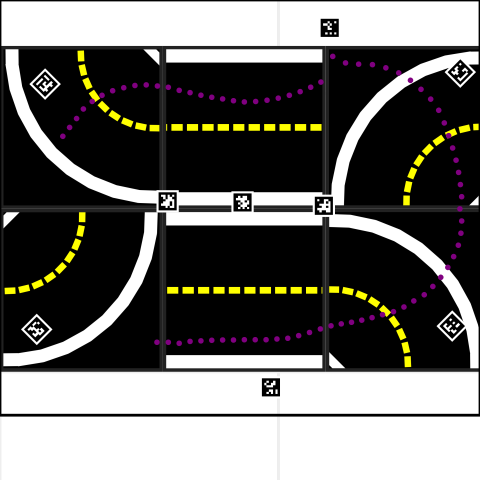

In [74]:
del m
m = dw.load_map('linus_loop')

# Create objects for drawing
for i, meant_tf in enumerate(mean_tfs):
    if not(i%2):
        m.set_object(str(i + 10000), Circle(0.01, color='purple'), ground_truth=meant_tf)
for i, meant_tf in enumerate(mean_tfs):
    m.set_object(str(i + 1000), AFakeBar(len=std_y[i], color='green'), ground_truth=meant_tf)

# Draw!
outdir = path.join('/home/linuslingg/out', "ipython_draw_svg", "%s" % id(m))

ipython_draw_svg(m);

Check if std of heading and lateral offset is low enough (check cv) like this we are sure that we can make after make a stable score sheet and compare it to other benchmarks.

In [31]:
for i in cv_y:
    if i > 1.0:
        print("Std of the lateral offset is too large")
for i in cv_heading:
    if i > 1.0:
        print("Std of the heading is too large")

In [39]:
lateral_deviation_tes = get_trajectories_statistics_mean_traj(mean_tfs, center_line_global_tfs)